In [1]:
import pandas as pd
import requests
import io
import os.path
from os import getcwd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union, List

## Phase 2

The class you decide the create for the project has finally been named after a brief fight and is PEP8 compliant, like the entire project.
The class will have several methods, which you will not develop in the master branch.
Document everything!
Make your calls compliant with Static Type Checking.

 One method will download the data file into a downloads/ directory in the root directory of the project (main project directory). If the data file already exists, the method will not download it again.
 This method must also read the dataset into a pandas dataframe which is an attribute of your class.

In [12]:
class Analysis:

    def __init__(self):
        self.dataframe = None

    def download_save_data(self):
        '''
        Downloads the agriculture data from a remote CSV file and saves it to a local file in a "downloads" directory.
        Returns the data as a pandas dataframe.
        '''

        #download data into dataframe part of the method
        url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv"
        download = requests.get(url).content
        self.dataframe = pd.read_csv(io.StringIO(download.decode('utf-8'))) #need to save into self.df

        #check directory and save file part of the method
        if not os.path.exists("downloads"):
            os.makedirs("downloads") #create directory called downloads
        if not os.path.isfile("downloads/Dataset.csv"):
            directory = getcwd()
            filename = directory + '/downloads/Dataset.csv'

            f = open(filename,'w')
            encoding = 'utf-8'
            down = download.decode(encoding)
            f.write(down)
            print("The file has been stored in the downloads directory with the name Dataset.csv")
        else:
            print("The path and file already exist")
        return self.dataframe
    
    def countries_list(self):
        '''
        Returns a list of all unique countries in the agriculture data.
        '''
        
        return self.dataframe["Entity"].unique().tolist()
    
    def plot_quantity_correlations(self):
        '''
        Plots a correlation matrix of the columns in the agriculture data that end with "_quantity".
        '''
        
        quantity_cols = [col for col in self.dataframe.columns if col.endswith('_quantity')]

        quantity_corr = self.dataframe[quantity_cols].corr()

        sns.heatmap(quantity_corr, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix of Quantity Columns')
        plt.show()
        
    def plot_output_area(self, entity, normalize):
        """
        Plots an area chart of crop, animal, and fish output quantities over time for a given entity.

        Args:
        - entity: str, the name of the entity to plot, e.g. "United States", or None to plot the world output.
        - normalize: bool, whether to normalize the output values as percentages.

        Returns:
        None
        """

        # Select the columns to plot
        columns_to_plot = ['crop_output_quantity', 'animal_output_quantity', 'fish_output_quantity']

        # Filter the dataset to include only the selected entity, or group by year to plot world output
        if entity is None or entity == 'World':
            df_plot = self.dataframe.groupby('Year').sum()[columns_to_plot]
            title = 'World Output'
        else:
            df_plot = self.dataframe[self.dataframe['Entity'] == entity].set_index('Year')[columns_to_plot]
            if df_plot.empty:
                raise ValueError(f"Entity '{entity}' not found")
            title = f"{entity} Output"

        # Normalize the output values if required
        if normalize is True:
            df_plot = df_plot.div(df_plot.sum(axis=1), axis=0) * 100

        # Plot the area chart
        df_plot.plot.area(title=title, xlabel='Year', ylabel='Output')
        plt.legend(loc='upper left')
        plt.title(title)
        plt.xlabel('Year')
        plt.ylabel('Output')
        plt.xticks(rotation=45)
        plt.show()
        
    def compare_output_for_countries(self, countries: Union[str, List[str]]):
        """
        Compare the total output of crop, animal, and fish for the specified countries over time.
        Plot a line graph to visualize the comparison.

        Parameters:
        -----------
        countries: str or List[str]
            A string or a list of strings containing the names of countries to compare.

        Returns:
        --------
        None
        """
        
        if isinstance(countries, str):
            countries = [countries]
        elif not isinstance(countries, list) or not all(isinstance(country, str) for country in countries):
            raise TypeError("Countries must be a string or a list of strings.")

        invalid_countries = set(countries) - set(self.dataframe['Entity'].unique())
        if invalid_countries:
            raise ValueError(f"The following countries are not in the dataset: {invalid_countries}")
    
        # Filter the dataframe to only include rows for the specified countries
        filtered_data = self.dataframe[self.dataframe['Entity'].isin(countries)].copy()

        # Calculate the total output for each country and year
        filtered_data.loc[:, 'Total Output'] = filtered_data[['crop_output_quantity', 'animal_output_quantity', 'fish_output_quantity']].sum(axis=1)
        total_output = filtered_data.groupby(['Entity', 'Year'])['Total Output'].sum().reset_index()

        # Create a line plot of the total output for each country over time
        for country in countries:
            country_data = total_output[total_output['Entity'] == country]
            plt.plot(country_data['Year'], country_data['Total Output'], label=country)

        # Add a legend to the plot indicating which line corresponds to each country
        plt.legend(title = 'Countries')

        # Add axis labels and a title to the plot
        plt.xlabel('Year')
        plt.ylabel('Total Output')
        plt.title('Comparison of Total Outputs among selected Countries over time')

        # Show the plot
        plt.show()
        
    def gapminder(self, year: int):
        """
        Creates a scatter plot of fertilizer quantity vs. output quantity, with bubble sizes representing irrigation quantity.
        The plot is colored by the specified year.

        Args:
            - year: int, the year to plot.

        Returns:
            None
        """
        if not isinstance(year, int):
            raise TypeError("Variable 'year' must be an integer")
            
        # Filter the data to include only the specified year
        filtered_data = self.dataframe[self.dataframe['Year'] == year]

        # Create the scatter plot
        sns.set_theme(style="white")
        colors = sns.color_palette('viridis', as_cmap=True)
        sns.relplot(x="fertilizer_quantity", y="output_quantity", size="irrigation_quantity", hue = "ag_land_quantity",
                sizes=(40, 400), alpha=.5, palette= colors, height=6, data=filtered_data, legend = 'brief')

        # Add axis labels and a title to the plot
        plt.xlabel('Fertilizer Quantity')
        plt.ylabel('Output Quantity')
        plt.title(f"Output vs. Fertilizer Quantity ({year})")

        # Show the plot
        plt.show()
        

In [13]:
Agros = Analysis()
Agros.download_save_data()

The path and file already exist


Entity  Year       tfp    output    inputs  ag_land_index  \
0      Afghanistan  1961   65.0814   44.8285   68.8807        91.6812   
1      Afghanistan  1962   64.0637   45.6182   71.2075        92.2016   
2      Afghanistan  1963   61.6217   45.9729   74.6051        92.6352   
3      Afghanistan  1964   65.1109   49.0775   75.3752        93.1816   
4      Afghanistan  1965   63.8587   51.2121   80.1960        93.1990   
...            ...   ...       ...       ...       ...            ...   
12177     Zimbabwe  2015  100.0000  100.0000  100.0000       100.0000   
12178     Zimbabwe  2016   94.8110   98.1051  103.4744       103.8526   
12179     Zimbabwe  2017  101.9830  104.9815  102.9402        99.6960   
12180     Zimbabwe  2018  118.1959  121.0832  102.4428       102.8520   
12181     Zimbabwe  2019  114.9524  114.2108   99.3549        92.5939   

       labor_index  capital_index  materials_index  output_quantity  ...  \
0          44.5145       141.5215          35.9132          2566730  ...   
1          45.0207       163.6547          36.3829          2611942  ...   
2          45.5528       202.0577          37.0801          2632254  ...   
3          46.1108       203.8875          37.5294          2810010  ...   
4          46.6948       270.9746          38.5949          2932230  ...   
...            ...            ...              ...              ...  ...   
12177     100.0000       100.0000         100.0000          2191374  ...   
12178     101.2662        97.9759         128.2406          2149850  ...   
12179     102.3605        96.4853         141.3410          2300538  ...   
12180     103.4662        95.3222         124.3694          2653386  ...   
12181     105.7368        94.1207         125.9910          2502786  ...   

       ag_land_quantity  labor_quantity  capital_quantity  machinery_quantity  \
0                 10571            1704              8866                   5   
1                 10631            1723             10253                   6   
2                 10681            1743             12659                   8   
3                 10744            1765             12773                   8   
4                 10746            1787             16976                  12   
...                 ...             ...               ...                 ...   
12177              2574            4184              8379                1154   
12178              2673            4237              8210                1174   
12179              2566            4283              8085                1180   
12180              2647            4330              7987                1201   
12181              2383            4425              7887                1210   

       livestock_quantity  fertilizer_quantity  animal_feed_quantity  \
0                    6339                57345               2068912   
1                    6228                58146               2082012   
2                    6547                59694               2007829   
3                    6732                60006               2140272   
4                    6946                61821               2171226   
...                   ...                  ...                   ...   
12177                5654                93807                975873   
12178                5705               146857               1000004   
12179                5601               160356               1113784   
12180                5681               146379                940395   
12181                5784               147631                957427   

       cropland_quantity  pasture_quantity  irrigation_quantity  
0                   7700             30000                 2380  
1                   7760             30000                 2380  
2                   7810             30000                 2380  
3                   7873             30000                 2380  
4                   7875             30000            

## Phase 3


### Method 2
Develop a second method that outputs a list of the available countries in the data set.

In [4]:
Agros.countries_list()

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Asia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Caribbean',
 'Central Africa',
 'Central African Republic',
 'Central America',
 'Central Asia',
 'Central Europe',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Developed Asia',
 'Developed countries',
 'Djibouti',
 'Dominican Republic',
 'East Africa',
 'Eastern Europe',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europe',
 'Fiji',
 'Finland',
 'Former Soviet Union',
 'France',
 'French Guian

### Method 3

Develop a third method that plots a way to correlate the "_quantity" columns.

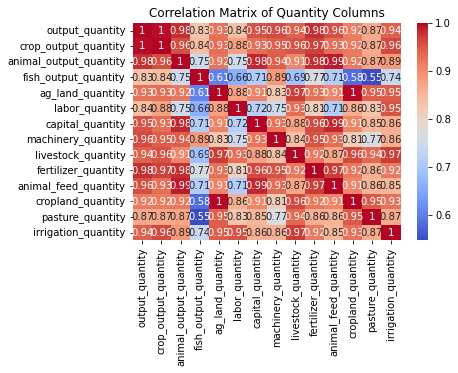

In [5]:
Agros.plot_quantity_correlations()

### Method 4

Develop a fourth method that plots an area chart of the distinct "_output_" columns. This method should have two arguments: a country argument and a normalize argument. The former, when receiving NONE or 'World' should plot the sum for all distinct countries. The latter, if True, normalizes the output in relative terms: each year, output should always be 100%. The X-axis should be the Year. The method should return a ValueError when the chosen country does not exist.

In [6]:
Agros.plot_output_area('Australia', False)   

### Method 5

Develop a fifth method that may receive a string with a country or a list of country strings. This method should compare the total of the "_output_" columns for each of the chosen countries and plot it, so a comparison can be made. The X-axis should be the Year.


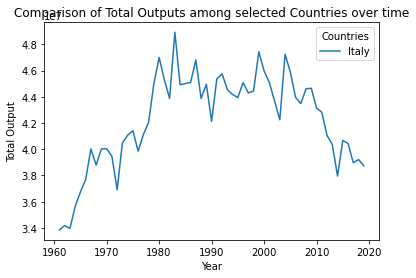

In [7]:
Agros.compare_output_for_countries('Italy')

### Method 6

Develop a sixth method that must be called gapminder. This is a reference to the famous gapminder tools. This method should receive an argument year which must be an int. If the received argument is not an int, the method should raise a TypeError. This method should plot a scatter plot where x is fertilizer_quantity, y is output_quantity, and the area of each dot should be a third relevant variable you find with exploration of the data.

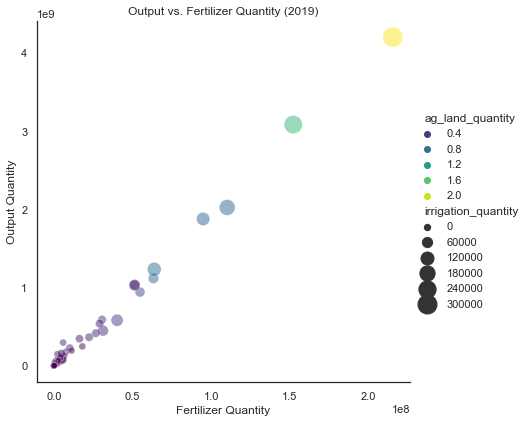

In [14]:
Agros.gapminder(2019)

The world agricultural production shows a different pattern based on the country considered and the year under consideration. First of all, we see how countries that use more fertilizers have a higher output quantity. We used the variable "irrigation_quantity" to check whether a higher use of fertilizers is accompagnied with a higher or lower amount of water used in the country. As shown in the graph, the amount of water used is higher. Nonetheless, this variable is absolute and we would need to compare it to overall land to have a more result.

[OPTIONAL] (to do): 
make a variable irrigation_quantity/total land and plot the graph with dot size equal to the ratio.